In [1]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch
import re
from gensim.test.utils import datapath
from gensim.models.fasttext import *
import gensim.downloader as api
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
cap_path = datapath(os.getcwd() + "/data/cc.en.300.bin.gz")
fbkv = load_facebook_vectors(cap_path)

In [3]:
w2v = api.load("word2vec-google-news-300") 

In [4]:
tokenizer = AutoTokenizer.from_pretrained("roberta-large")
model = AutoModelWithLMHead.from_pretrained("roberta-large")

In [5]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':100})

In [83]:
def lget(lst, pos):
    return list(map(lambda x: x[pos], lst))

def dget(lst, pos):    
    return list(map(lambda x: '{0:.2f}'.format(x[pos]), lst))

def mk_graph(x1, x2):
    x1 = list(filter(lambda x: x > -2 and x < 0.99, x1))[:40]
    x2 = list(filter(lambda x: x > -2 and x < 0.99, x2))[:40]
    kwargs = dict(alpha=0.3, bins=20)

    plt.hist(x1, **kwargs, color='g', label='FastText score')
    plt.hist(x2, **kwargs, color='b', label='Word2Vec score')
    plt.gca().set(title='Top 40 masks histogram of embeddings score', ylabel='Count')

    plt.legend()
    plt.show()
    
def mk_graph2(x1):
    kwargs = dict(alpha=1, bins=50)

    plt.hist(x1, **kwargs, color='r', label='Weighted score')
    plt.gca().set(title='Distribution of weighted score of top 200 unfiltered results (Target excluded)', ylabel='Count')

    plt.legend()
    plt.show()
    
def calc_w(x, y, z, w):
    return x * w[0] + y * w[1] + z * w[2]

def find_top(sentence, k, top_bert, bert_norm, min_ftext, min_w2v, weights): 
    print("Input: ", sentence)
    smatch = re.search("(\w+)\?", sentence)
    target = None
    
    if (smatch):
        target = re.sub("\?", "", smatch.group(0))
        target = target.strip()
        
    sequence = re.sub("(\w+)?\?", tokenizer.mask_token, sentence)

    input = tokenizer.encode(sequence, return_tensors="pt")
    mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

    token_logits = model(input)[0]
    mask_token_logits = token_logits[0, mask_token_index, :]

    # Filter top <top_bert> results of bert output
    topk = torch.topk(mask_token_logits, top_bert, dim=1)
    top_tokens = list(zip(topk.indices[0].tolist(), topk.values[0].tolist()))

    unfiltered = list()
    filtered = list()
    
    norm_d = top_tokens[bert_norm - 1][1]
    norm_k = top_tokens[0][1] - norm_d
    
    # Filter bert output by <min_ftext> and <min_w2v>
    for token, value in top_tokens:
        word = tokenizer.decode([token]).strip()
        nvalue = (value - norm_d) / norm_k
        sim = None

        sim = fbkv.similarity(target, word)
        try:
            sim2 = w2v.similarity(target, word)
        except:
            sim2 = -2

        if (sim >= min_ftext and sim2 >= min_w2v):
            filtered.append((word, value, nvalue, sim, sim2, calc_w(nvalue, sim, sim2, weights)))
                
        unfiltered.append((word, value, nvalue, sim, sim2, calc_w(nvalue, sim, sim2, weights)))
        
    kfiltered = filtered[:k]
    kunfiltered = unfiltered[:k]
    
    kfiltered = sorted(kfiltered, key = lambda x: -x[5])
    kunfiltered = sorted(kunfiltered, key = lambda x: -x[5])
  
    if (min_ftext > 0 and min_w2v > 0):
        print("Unfiltered top:")

        print(pd.DataFrame({
            'word': lget(kunfiltered, 0),
            'bert': dget(kunfiltered, 1),
            'normalized': dget(kunfiltered, 2),
            'ftext': dget(kunfiltered, 3),
            'w2vec': dget(kunfiltered, 4),
            'score': dget(kunfiltered, 5)
        }))
    
    print("Filtered top:")
        
    print(pd.DataFrame({
        'word': lget(kfiltered, 0),
        'bert': dget(kfiltered, 1),
        'normalized': dget(kfiltered, 2),
        'ftext': dget(kfiltered, 3),
        'w2vec': dget(kfiltered, 4),
        'score': dget(kfiltered, 5)
    }))
    
    mk_graph(lget(unfiltered, 2)[:100], lget(unfiltered, 3)[:100])
    mk_graph2(lget(list(filter(lambda x: x[0] != target, unfiltered)), 5))
        
    if (target != None):
        vec = tokenizer.encode(target, return_tensors="pt")[0]
        if (len(vec) == 3):
            tk = vec[1].item()
            pos = None
            score = None
            
            for e, (t, v) in enumerate(top_tokens):
                if (t == tk):
                    pos = e
                    score = v
                    break
            print("Original word position: ", e, "; score: ", score)
        else: 
            if (len(vec) > 3):
                print("Original word is more then 1 token")
                print(tokenizer.tokenize(target))
            else:
                print("Original word wasn't found")
    print("===================")
    
def do_find(s):
    find_top(s, 20, 200, 200, 0.25, 0.25, [1, 1, 1]) 
    
base_samples = [
    "what's the local weather? forecast",
    "chance of rain? tomorrow in Moscow",
    "chance of rain? tomorrow in city",
    "set the lights? on in the entire house",
    "set the lights on in the entire house?",
    "turn the lights off in the guest? bedroom",
    "turn the lights off in the guest bedroom?"
]

## Random wiki how to articles
articles = [
    "how to use a sharpening steel?",
    "how to identify? and treat liver shunts in cats",
    "how to identify and treat? liver shunts in cats",
    "how to identify and treat liver? shunts in cats",
    "use enamel paint? on a stove",
    "escape a sinking? ship",
    "escape a sinking ship?",
    "reduce the effect? of macular degeneration",
    "recognize sign? of an abusive person",
    "recognize signs of an abusive person?",
    "make wine? vinegar",
    "prepare boneless skinless chicken? thighs",
    "what can you eat with type 2 diabetes?"
]

Input:  what's the local weather? forecast
Unfiltered top:
             word   bert normalized ftext w2vec score
0         weather  58.94       1.00  1.00  1.00  3.00
1            rain  54.68       0.50  0.58  0.57  1.66
2            snow  55.37       0.59  0.49  0.52  1.59
3        rainfall  54.86       0.53  0.50  0.47  1.50
4     temperature  55.83       0.64  0.45  0.39  1.47
5          winter  53.39       0.35  0.55  0.55  1.46
6           storm  53.71       0.39  0.50  0.50  1.39
7   precipitation  54.29       0.46  0.41  0.47  1.34
8         traffic  54.94       0.53  0.32  0.28  1.14
9         weekend  54.44       0.48  0.35  0.27  1.09
10           heat  53.66       0.39  0.37  0.33  1.08
11        tornado  53.73       0.39  0.34  0.32  1.06
12        heating  53.61       0.38  0.29  0.28  0.95
13          radar  53.73       0.39  0.32  0.23  0.94
14         travel  53.82       0.40  0.26  0.24  0.90
15        morning  53.34       0.35  0.30  0.25  0.89
16           fire  53.7

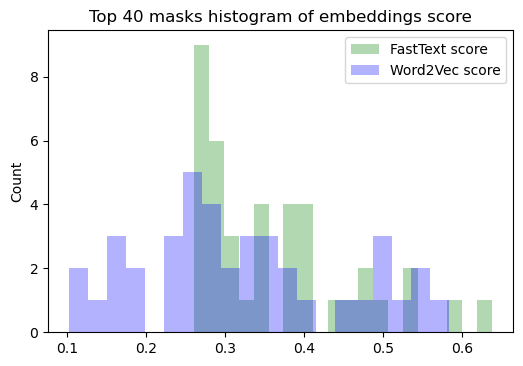

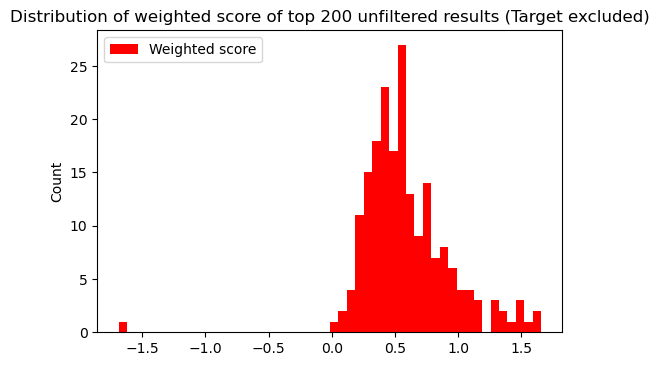

Original word position:  0 ; score:  58.944068908691406
Input:  chance of rain? tomorrow in Moscow
Unfiltered top:
          word   bert normalized ftext w2vec score
0     protests  56.42       1.00  0.13  0.14  1.27
1      protest  55.55       0.82  0.14  0.10  1.06
2    fireworks  54.10       0.53  0.28  0.24  1.05
3        march  54.19       0.54  0.23  0.18  0.96
4        Putin  55.87       0.89  0.01  0.03  0.92
5        peace  54.64       0.64  0.12  0.15  0.91
6       events  54.42       0.59  0.12  0.15  0.85
7     violence  53.88       0.48  0.19  0.16  0.83
8      rallies  53.99       0.50  0.13  0.18  0.81
9     Olympics  54.79       0.67  0.08  0.01  0.76
10   emergency  53.95       0.50  0.15  0.10  0.75
11      Terror  54.45       0.60  0.04  0.09  0.73
12  Revolution  54.09       0.52  0.07  0.12  0.71
13        life  53.65       0.43  0.16  0.11  0.71
14      speech  53.81       0.47  0.11  0.01  0.59
15  revolution  53.81       0.47  0.08  0.04  0.59
16      Russia  54

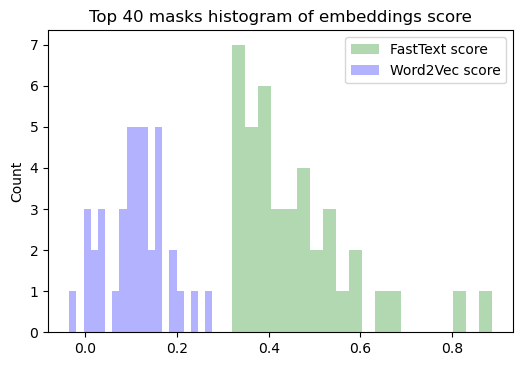

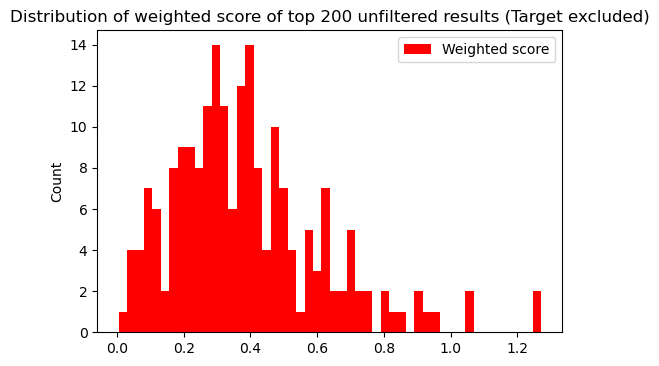

Original word position:  199 ; score:  None
Input:  chance of rain? tomorrow in city
Unfiltered top:
         word   bert normalized ftext w2vec score
0        rain  56.93       0.87  1.00  1.00  2.87
1        snow  56.99       0.89  0.59  0.63  2.10
2      storms  55.70       0.53  0.55  0.51  1.58
3   fireworks  57.38       1.00  0.28  0.24  1.52
4    flooding  55.76       0.54  0.48  0.49  1.51
5    violence  56.53       0.76  0.19  0.16  1.11
6    protests  56.79       0.83  0.13  0.14  1.11
7     eclipse  56.04       0.62  0.21  0.17  1.00
8    homeless  56.10       0.64  0.16  0.15  0.95
9    concerts  56.00       0.61  0.13  0.17  0.92
10     police  55.85       0.57  0.15  0.13  0.85
11   meetings  56.24       0.68  0.06  0.10  0.84
12    arrests  55.80       0.55  0.11  0.15  0.82
13  thousands  55.87       0.58  0.13  0.12  0.82
14     events  55.80       0.56  0.12  0.15  0.82
15     action  55.75       0.54  0.12  0.16  0.81
16    schools  56.07       0.63  0.08  0.10  0.81

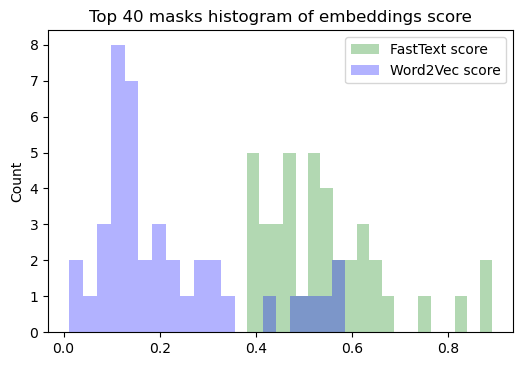

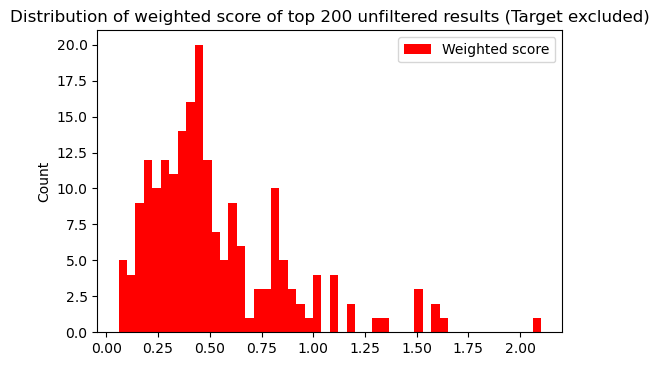

Original word position:  2 ; score:  56.93498992919922
Input:  set the lights? on in the entire house
Unfiltered top:
           word   bert normalized ftext w2vec score
0        lights  61.43       1.00  1.00  1.00  3.00
1         light  58.84       0.73  0.63  0.55  1.92
2      lighting  56.02       0.45  0.71  0.67  1.83
3         lamps  56.34       0.48  0.68  0.58  1.73
4          heat  60.00       0.85  0.25  0.26  1.36
5   electricity  58.08       0.66  0.36  0.32  1.34
6       heating  58.15       0.66  0.26  0.28  1.20
7        heater  56.83       0.53  0.32  0.33  1.18
8         power  57.69       0.62  0.29  0.25  1.16
9         stove  56.83       0.53  0.28  0.31  1.12
10        water  58.60       0.71  0.22  0.19  1.12
11           AC  58.90       0.74  0.17  0.18  1.10
12         fans  58.79       0.73  0.20  0.16  1.08
13      furnace  56.99       0.55  0.23  0.27  1.05
14         oven  56.71       0.52  0.24  0.22  0.98
15           TV  57.68       0.62  0.17  0.16  0.9

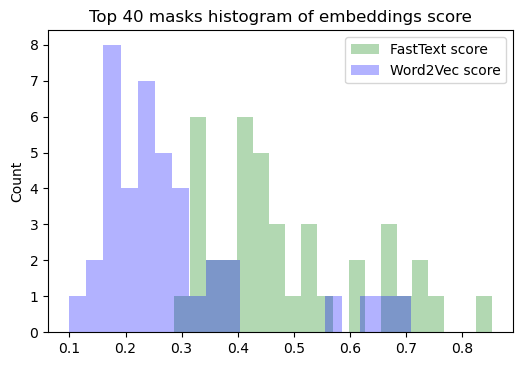

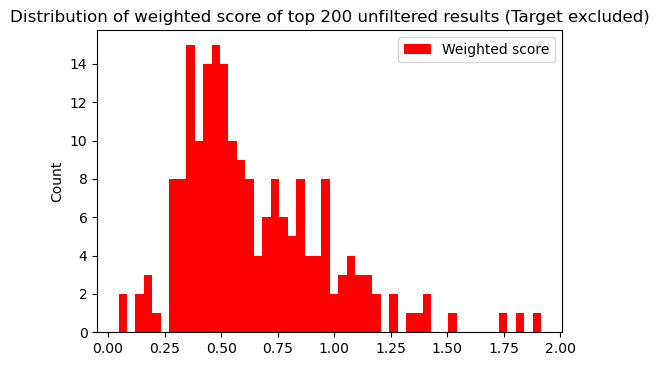

Original word position:  0 ; score:  61.43402862548828
Input:  set the lights on in the entire house?
Unfiltered top:
          word   bert normalized ftext w2vec score
0        house  63.09       0.91  1.00  1.00  2.91
1         room  63.75       1.00  0.51  0.46  1.96
2    apartment  60.14       0.52  0.65  0.66  1.84
3         home  59.97       0.50  0.65  0.56  1.71
4     basement  60.36       0.55  0.59  0.49  1.63
5     building  61.14       0.65  0.51  0.44  1.60
6      kitchen  60.34       0.55  0.48  0.47  1.50
7        cabin  59.91       0.49  0.50  0.45  1.43
8     bathroom  60.08       0.51  0.45  0.39  1.35
9          car  59.98       0.50  0.44  0.39  1.32
10      office  60.46       0.56  0.39  0.32  1.27
11   warehouse  59.56       0.44  0.39  0.41  1.24
12        shop  59.66       0.45  0.38  0.38  1.22
13        area  60.70       0.59  0.32  0.29  1.21
14       store  60.07       0.51  0.32  0.32  1.15
15  restaurant  59.55       0.44  0.37  0.32  1.13
16     hallway 

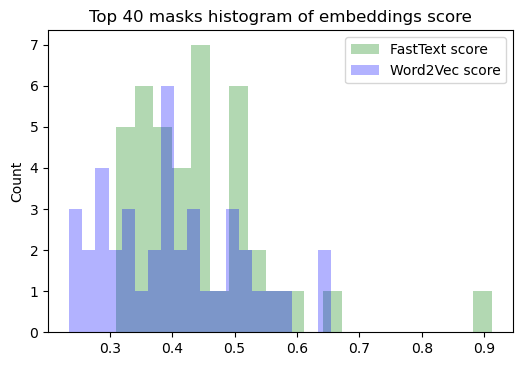

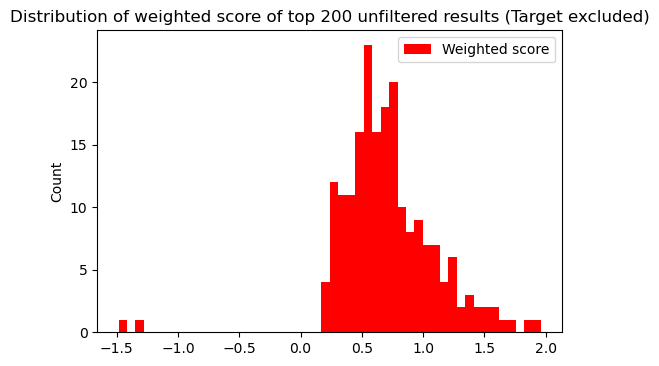

Original word position:  1 ; score:  63.09485626220703
Input:  turn the lights off in the guest? bedroom
Unfiltered top:
          word   bert normalized ftext w2vec score
0        guest  60.63       0.83  1.00  1.00  2.83
1       master  62.26       1.00  0.26  0.17  1.42
2     upstairs  58.48       0.62  0.30  0.21  1.13
3       second  59.89       0.76  0.21  0.09  1.06
4   downstairs  57.80       0.55  0.28  0.21  1.04
5        third  58.97       0.67  0.24  0.09  1.00
6         main  58.72       0.64  0.24  0.10  0.98
7        spare  59.19       0.69  0.18  0.11  0.98
8        other  58.33       0.60  0.19  0.12  0.91
9        first  57.30       0.50  0.26  0.09  0.84
10       front  58.01       0.57  0.18  0.09  0.84
11       extra  56.93       0.46  0.26  0.10  0.83
12      family  56.44       0.41  0.28  0.13  0.82
13   adjoining  56.27       0.39  0.23  0.15  0.77
14      Master  56.86       0.45  0.16  0.16  0.77
15        back  58.61       0.63  0.12  0.01  0.76
16        ne

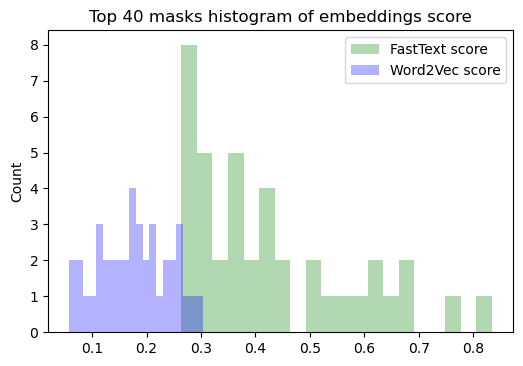

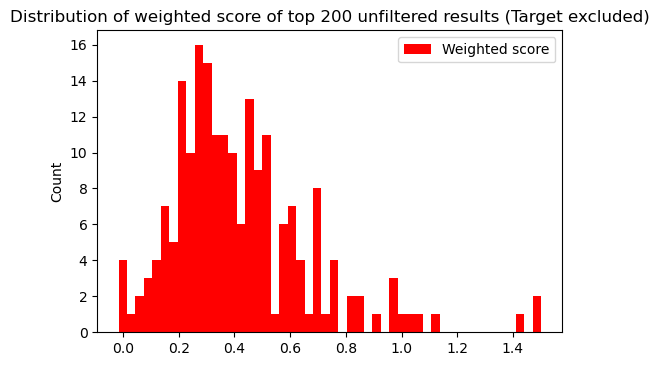

Original word position:  1 ; score:  60.62987518310547
Input:  turn the lights off in the guest bedroom?
Unfiltered top:
         word   bert normalized ftext w2vec score
0     bedroom  61.55       0.87  1.00  1.00  2.87
1    bedrooms  59.71       0.70  0.76  0.78  2.25
2    bathroom  60.76       0.80  0.70  0.62  2.12
3        room  62.96       1.00  0.60  0.51  2.11
4       rooms  61.59       0.88  0.50  0.48  1.85
5        room  60.06       0.74  0.60  0.51  1.85
6        bath  58.99       0.64  0.59  0.55  1.78
7       house  58.14       0.56  0.57  0.65  1.78
8       house  58.11       0.56  0.57  0.65  1.78
9         bed  57.82       0.53  0.60  0.52  1.66
10      rooms  59.17       0.66  0.50  0.48  1.63
11  bathrooms  57.79       0.53  0.55  0.46  1.54
12      cabin  58.14       0.56  0.38  0.46  1.40
13      suite  57.81       0.53  0.49  0.32  1.34
14     lounge  56.86       0.45  0.46  0.33  1.23
15     suites  57.06       0.46  0.42  0.33  1.22
16   restroom  56.88       0.

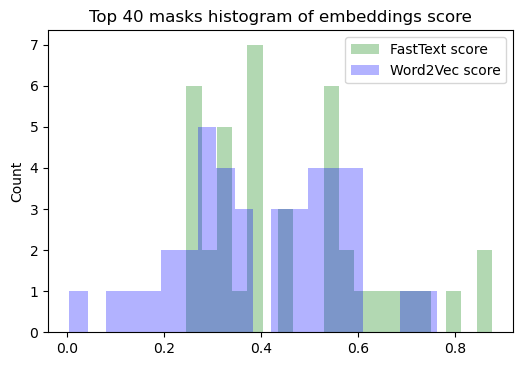

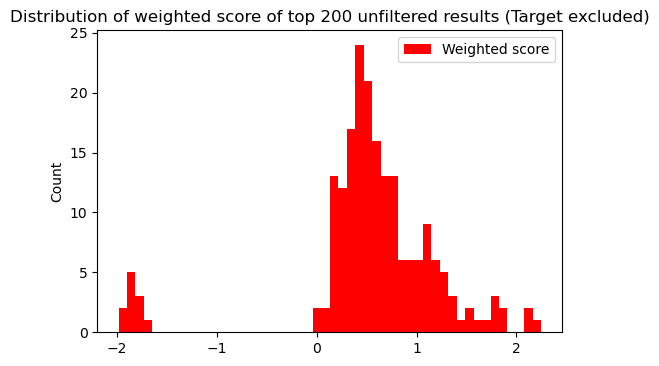

Original word position:  2 ; score:  61.55071258544922


In [84]:
for s in base_samples:
    do_find(s)

Input:  how to use a sharpening steel?
Unfiltered top:
          word   bert normalized ftext w2vec score
0        steel  52.06       0.50  1.00  1.00  2.50
1         iron  54.96       0.90  0.59  0.45  1.94
2        stone  54.87       0.89  0.42  0.32  1.64
3        knife  55.37       0.96  0.33  0.10  1.39
4       pencil  55.19       0.94  0.26  0.13  1.33
5        wheel  54.34       0.82  0.28  0.16  1.25
6        blade  52.89       0.61  0.39  0.24  1.25
7         tool  55.64       1.00  0.19  0.04  1.23
8          pen  53.86       0.75  0.22  0.06  1.03
9        brush  53.13       0.65  0.21  0.06  0.92
10       spoon  52.13       0.51  0.27  0.14  0.91
11         bar  52.10       0.50  0.28  0.12  0.90
12         pin  52.42       0.55  0.22  0.11  0.87
13      device  53.61       0.71  0.10  0.05  0.86
14       stick  52.60       0.57  0.21  0.08  0.86
15  instrument  51.97       0.48  0.21  0.16  0.86
16         tip  52.83       0.60  0.18  0.07  0.86
17     surface  52.01      

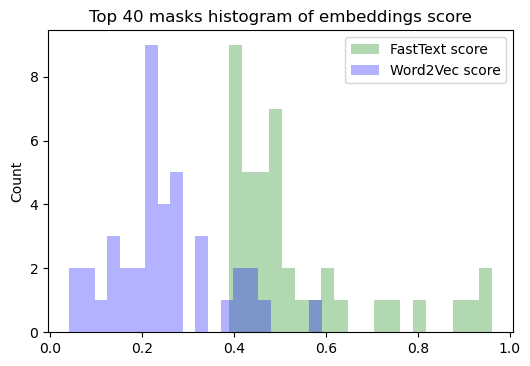

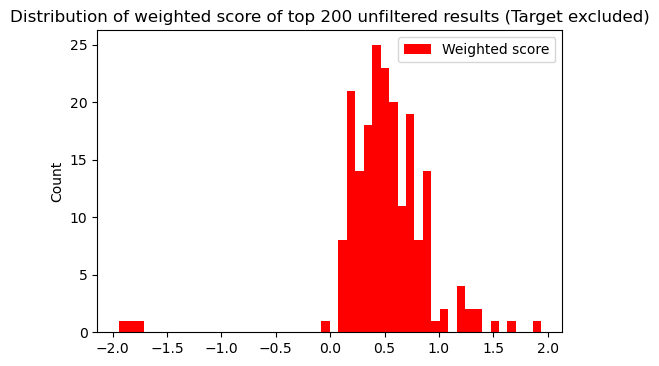

Original word position:  16 ; score:  52.06224060058594
Input:  how to identify? and treat liver shunts in cats
Unfiltered top:
         word   bert normalized ftext w2vec score
0    identify  59.71       0.79  1.00  1.00  2.79
1    diagnose  61.97       1.00  0.51  0.47  1.98
2      detect  59.45       0.76  0.62  0.56  1.94
3   recognize  58.66       0.69  0.61  0.53  1.83
4      locate  56.84       0.52  0.63  0.65  1.79
5        find  59.16       0.74  0.53  0.51  1.77
6      assess  56.01       0.44  0.66  0.51  1.61
7    evaluate  56.10       0.45  0.61  0.50  1.56
8     prevent  60.22       0.84  0.41  0.29  1.53
9    discover  55.95       0.44  0.49  0.49  1.42
10    isolate  55.86       0.43  0.54  0.45  1.42
11    monitor  57.19       0.55  0.40  0.38  1.34
12    predict  56.21       0.46  0.48  0.36  1.30
13       spot  60.44       0.86  0.28  0.10  1.24
14        see  55.89       0.43  0.40  0.34  1.17
15      avoid  56.64       0.50  0.40  0.25  1.15
16      catch  57.06  

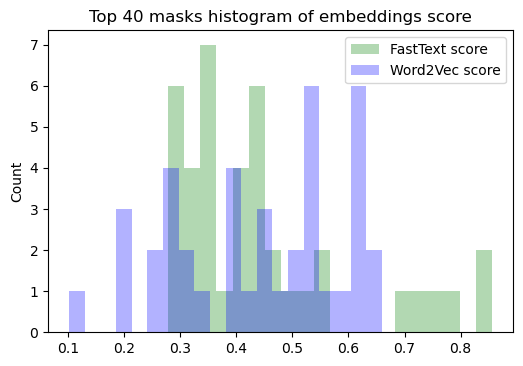

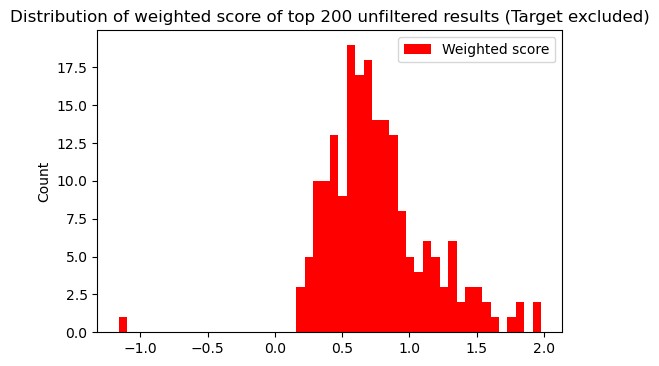

Original word position:  3 ; score:  59.7053337097168
Input:  how to identify and treat? liver shunts in cats
Unfiltered top:
        word   bert normalized ftext w2vec score
0      treat  62.70       1.00  1.00  1.00  3.00
1   diagnose  58.35       0.55  0.49  0.49  1.53
2     manage  59.27       0.65  0.34  0.31  1.30
3    prevent  59.01       0.62  0.41  0.24  1.27
4       cure  57.31       0.45  0.41  0.39  1.25
5       heal  56.64       0.38  0.36  0.37  1.11
6     remove  58.88       0.61  0.23  0.25  1.09
7     detect  56.89       0.40  0.32  0.35  1.07
8   evaluate  56.52       0.37  0.31  0.39  1.07
9        fix  57.18       0.43  0.29  0.26  0.98
10    induce  56.84       0.40  0.31  0.25  0.96
11   monitor  57.48       0.46  0.20  0.28  0.95
12      stop  57.51       0.47  0.31  0.16  0.94
13    repair  58.93       0.61  0.14  0.13  0.89
14   measure  56.67       0.38  0.22  0.20  0.80
15   restore  56.65       0.38  0.22  0.20  0.80
16   address  56.52       0.37  0.18  0.2

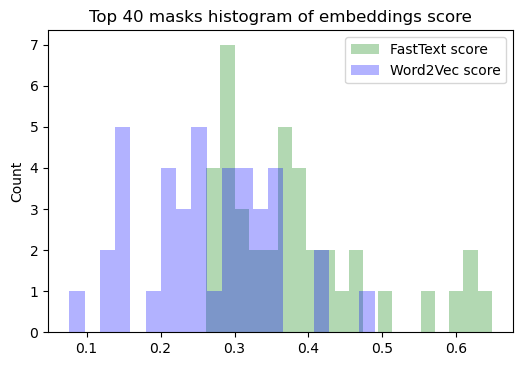

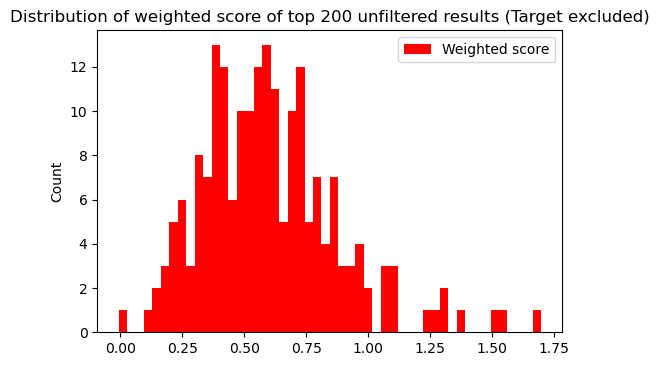

Original word position:  0 ; score:  62.69602584838867
Input:  how to identify and treat liver? shunts in cats
Unfiltered top:
           word   bert normalized ftext  w2vec score
0         liver  55.42       0.61  1.00   1.00  2.61
1       urinary  57.67       1.00  0.39   0.45  1.84
2       thyroid  56.21       0.75  0.53   0.51  1.79
3    intestinal  55.39       0.60  0.51   0.55  1.66
4         heart  55.48       0.62  0.41   0.45  1.48
5       bladder  54.98       0.53  0.42   0.51  1.47
6   respiratory  55.55       0.63  0.37   0.42  1.43
7    autoimmune  54.81       0.50  0.40   0.47  1.37
8         blood  54.92       0.52  0.40   0.42  1.34
9        spinal  54.95       0.53  0.30   0.45  1.28
10        spine  55.13       0.56  0.28   0.37  1.21
11         tail  56.33       0.77  0.25   0.18  1.20
12          ear  55.92       0.69  0.25   0.25  1.19
13      chronic  54.90       0.52  0.37   0.30  1.18
14        nasal  55.31       0.59  0.22   0.35  1.16
15         neck  55.26   

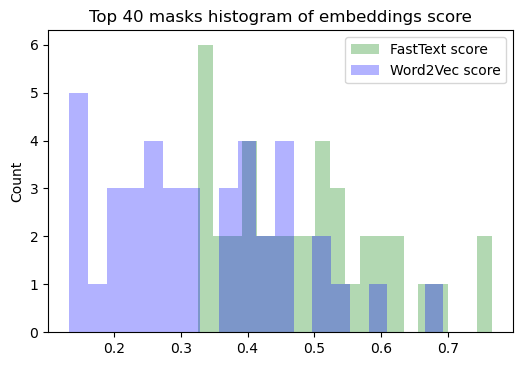

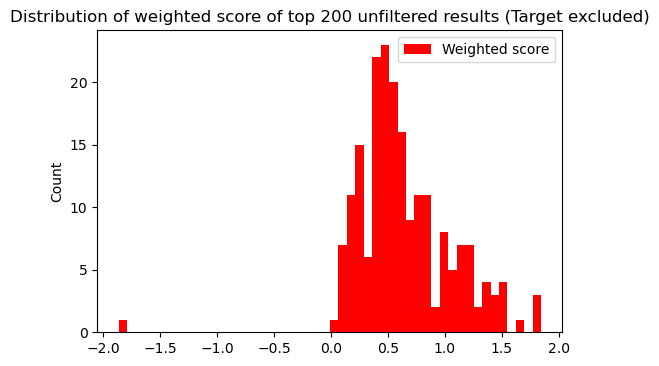

Original word position:  7 ; score:  55.418087005615234
Input:  use enamel paint? on a stove
Unfiltered top:
        word   bert normalized  ftext w2vec score
0      paint  54.75       0.60   1.00  1.00  2.60
1     paints  54.43       0.54   0.75  0.66  1.95
2   painting  54.28       0.51   0.70  0.54  1.74
3    coating  55.35       0.71   0.45  0.35  1.51
4       pots  56.63       0.95   0.31  0.20  1.46
5        pot  56.88       1.00   0.24  0.12  1.35
6        pan  56.84       0.99   0.21  0.13  1.33
7       pans  55.69       0.78   0.23  0.19  1.19
8        oil  54.79       0.60   0.35  0.18  1.14
9       jars  55.53       0.75   0.25  0.13  1.13
10       jar  54.92       0.63   0.24  0.15  1.02
11     sauce  54.05       0.47   0.27  0.15  0.88
12       egg  54.09       0.47   0.22  0.15  0.84
13      ware  54.03       0.46   0.21  0.16  0.83
14      oven  54.51       0.55   0.17  0.11  0.83
15      dish  54.54       0.56   0.14  0.11  0.80
16     tubes  54.02       0.46   0.21  0.

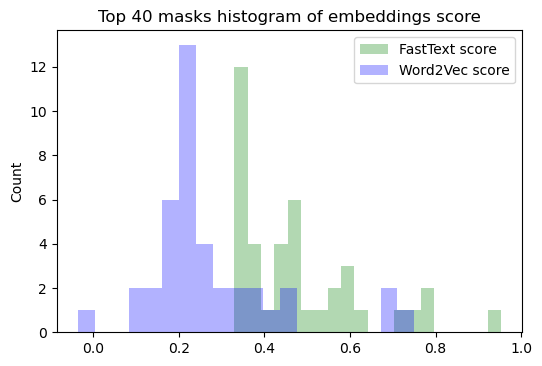

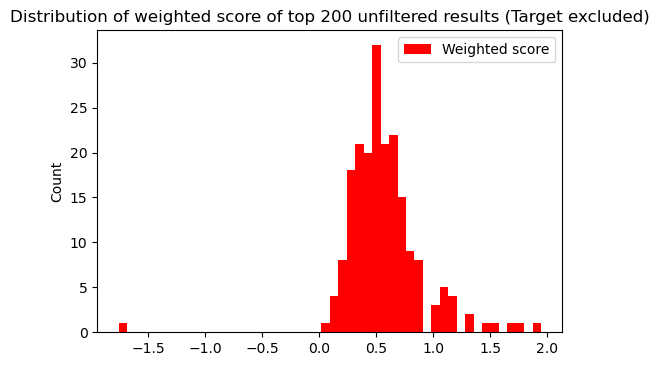

Original word position:  9 ; score:  54.7498779296875
Input:  escape a sinking? ship
Unfiltered top:
         word   bert normalized ftext  w2vec score
0     sinking  56.10       0.64  1.00   1.00  2.64
1      cruise  58.43       1.00  0.33   0.29  1.62
2       cargo  56.79       0.75  0.27   0.12  1.13
3     sailing  54.57       0.41  0.38   0.33  1.12
4      pirate  56.48       0.70  0.20   0.21  1.11
5       ghost  55.46       0.54  0.15   0.18  0.87
6   container  55.71       0.58  0.17   0.08  0.83
7        Navy  54.35       0.37  0.24   0.21  0.83
8      rocket  54.86       0.45  0.18   0.18  0.81
9        tall  55.66       0.57  0.12   0.11  0.80
10  passenger  55.33       0.53  0.19   0.07  0.79
11      small  55.66       0.57  0.09   0.06  0.73
12        big  54.54       0.40  0.17   0.12  0.69
13        new  55.23       0.51  0.12   0.07  0.69
14      slave  54.34       0.37  0.13   0.16  0.66
15      large  54.77       0.44  0.16   0.06  0.66
16     mother  54.80       0.44 

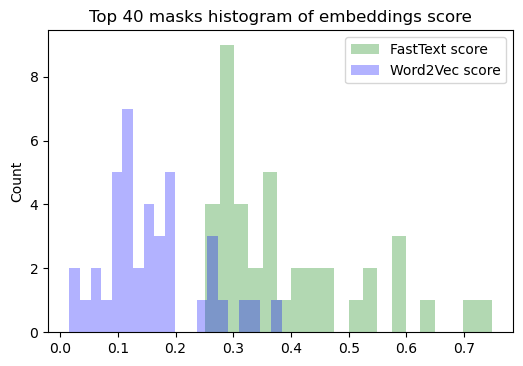

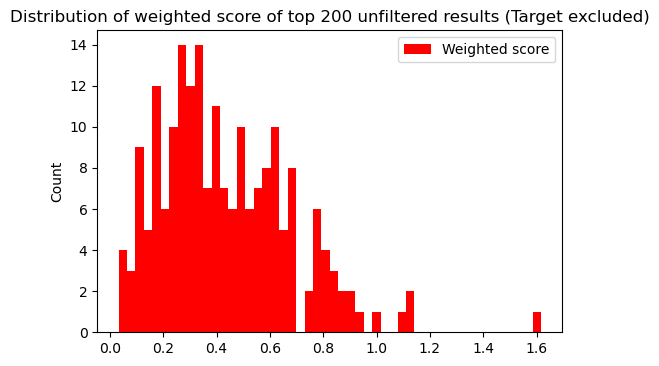

Original word position:  3 ; score:  56.103729248046875
Input:  escape a sinking ship?
Unfiltered top:
        word   bert normalized ftext  w2vec  score
0       ship  61.24       1.00  1.00   1.00   3.00
1     vessel  57.68       0.59  0.61   0.75   1.95
2       boat  58.32       0.66  0.55   0.62   1.83
3       Ship  56.07       0.40  0.61   0.67   1.67
4       dock  55.24       0.30  0.48   0.52   1.31
5    Titanic  55.90       0.38  0.46   0.43   1.27
6      train  55.96       0.38  0.29   0.28   0.96
7     planet  56.00       0.39  0.34   0.19   0.92
8      liner  55.23       0.30  0.32   0.27   0.89
9      world  56.74       0.48  0.24   0.12   0.83
10   economy  56.64       0.46  0.21   0.15   0.82
11  building  55.57       0.34  0.24   0.18   0.76
12     house  55.49       0.33  0.22   0.18   0.73
13      city  56.41       0.44  0.18   0.04   0.66
14      town  55.57       0.34  0.19   0.08   0.61
15      star  55.81       0.37  0.19   0.04   0.60
16     state  55.45       0.33

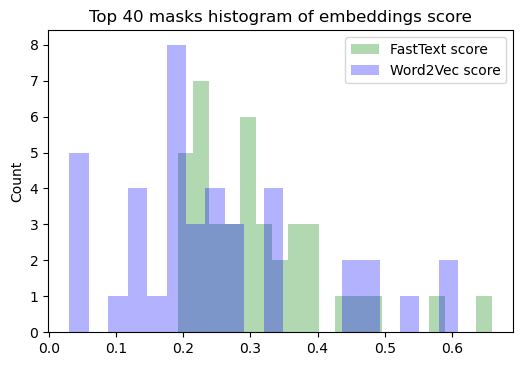

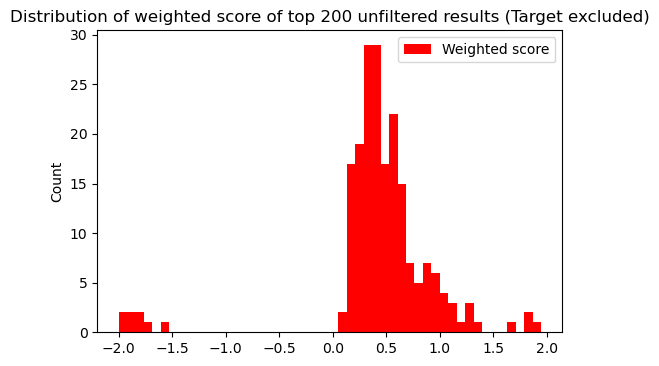

Original word position:  0 ; score:  61.24334716796875
Input:  reduce the effect? of macular degeneration
Unfiltered top:
           word   bert normalized ftext w2vec score
0       effects  56.85       0.85  0.75  0.64  2.24
1        impact  55.53       0.60  0.64  0.65  1.89
2        causes  57.66       1.00  0.36  0.22  1.58
3         cause  56.33       0.75  0.42  0.28  1.46
4         onset  56.84       0.85  0.27  0.26  1.38
5          risk  57.11       0.90  0.20  0.24  1.34
6      symptoms  57.25       0.92  0.22  0.16  1.30
7         signs  57.17       0.91  0.19  0.15  1.25
8    mechanisms  55.96       0.68  0.34  0.23  1.24
9         risks  56.01       0.69  0.24  0.24  1.17
10  progression  56.21       0.73  0.23  0.20  1.16
11      process  55.71       0.63  0.26  0.16  1.04
12      problem  55.17       0.53  0.26  0.22  1.01
13    beginning  55.07       0.51  0.19  0.24  0.94
14      biology  56.03       0.69  0.06  0.07  0.82
15       course  55.05       0.51  0.18  0.12 

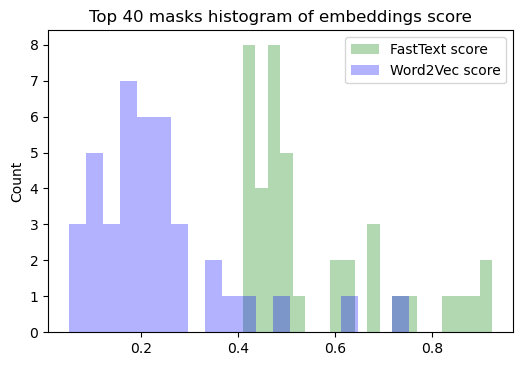

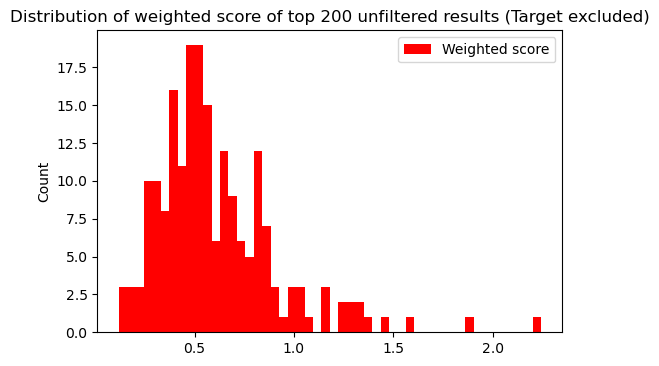

Original word position:  40 ; score:  54.533267974853516
Input:  recognize sign? of an abusive person
Unfiltered top:
               word   bert normalized  ftext  w2vec  score
0              sign  48.84       0.53   1.00   1.00   2.53
1             signs  49.38       0.66   0.72   0.71   2.09
2          symptoms  49.41       0.67   0.20   0.18   1.05
3          behavior  49.76       0.75   0.15   0.09   0.99
4              life  50.07       0.82   0.07   0.02   0.91
5              face  48.66       0.49   0.20   0.18   0.87
6            victim  49.03       0.58   0.10   0.13   0.81
7              fear  48.66       0.49   0.18   0.14   0.81
8            traits  48.95       0.56   0.13   0.09   0.78
9   characteristics  49.50       0.69   0.08   0.00   0.78
10       definition  48.89       0.54   0.11   0.05   0.70
11             ence  49.19       0.62   0.02   0.00   0.64
12          actions  49.06       0.58   0.04  -0.00   0.62
13             ives  48.70       0.50   0.10   0.02   0.

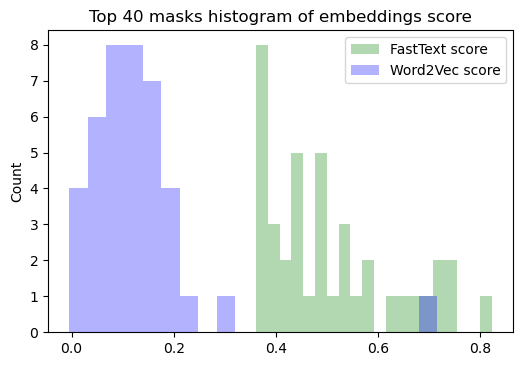

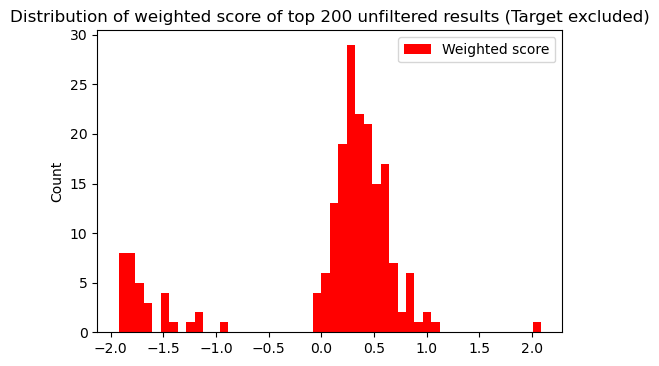

Original word position:  15 ; score:  48.83759307861328
Input:  recognize signs of an abusive person?
Unfiltered top:
             word   bert normalized ftext  w2vec score
0          person  56.78       0.40  1.00   1.00  2.40
1          spouse  60.88       0.77  0.39   0.41  1.57
2             man  57.29       0.45  0.56   0.53  1.54
3    relationship  63.47       1.00  0.27   0.07  1.34
4         partner  61.52       0.83  0.30   0.14  1.27
5         husband  58.80       0.58  0.34   0.27  1.19
6          parent  58.18       0.53  0.36   0.29  1.18
7       boyfriend  59.11       0.61  0.32   0.24  1.17
8      girlfriend  57.34       0.45  0.33   0.23  1.02
9           lover  57.01       0.42  0.33   0.27  1.02
10           wife  57.25       0.44  0.33   0.25  1.01
11       marriage  59.98       0.69  0.20   0.13  1.01
12         family  56.42       0.37  0.32   0.28  0.98
13      situation  57.74       0.49  0.29   0.19  0.96
14         father  56.80       0.40  0.30   0.23  0.93
15

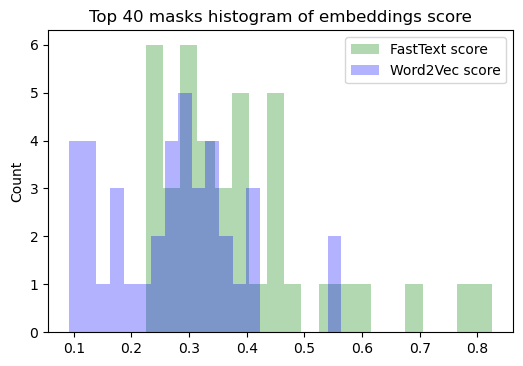

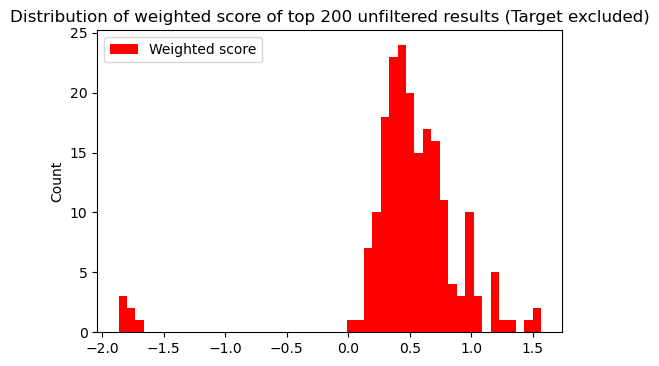

Original word position:  15 ; score:  56.78102111816406
Input:  make wine? vinegar
Unfiltered top:
     word   bert normalized ftext  w2vec  score
0    wine  46.52       0.54  1.00   1.00   2.54
1   cider  47.56       0.72  0.53   0.52   1.77
2     ine  49.17       1.00  0.14   0.11   1.25
3   apple  45.91       0.43  0.32   0.39   1.15
4   white  46.90       0.60  0.28   0.12   1.00
5    rape  47.54       0.72  0.11   0.08   0.90
6     ice  46.23       0.49  0.26   0.14   0.89
7      in  46.73       0.57  0.08   0.06   0.72
8    ugar  46.27       0.50  0.16   0.05   0.71
9     ave  46.26       0.49  0.09   0.10   0.68
10     le  45.82       0.42  0.13   0.10   0.65
11    ise  46.23       0.49  0.06   0.06   0.61
12   with  45.87       0.43  0.13   0.05   0.61
13     in  45.90       0.43  0.08   0.06   0.58
14   andy  45.81       0.41  0.06   0.08   0.56
15  herry  48.14       0.82  0.21  -2.00  -0.97
16    and  47.98       0.79  0.20  -2.00  -1.01
17  emade  46.43       0.52  0.05  -2

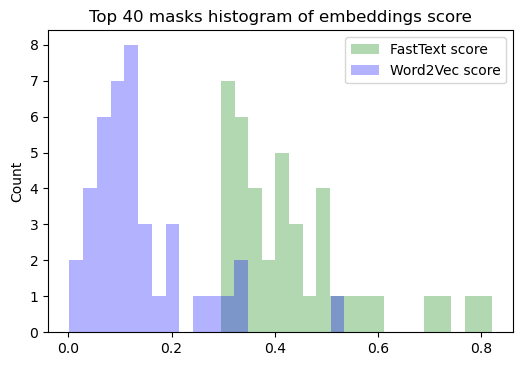

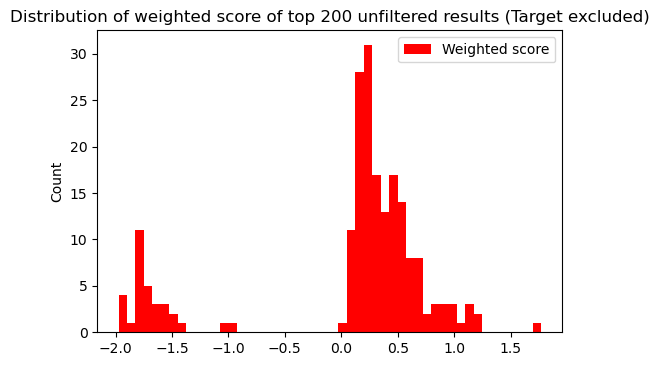

Original word position:  7 ; score:  46.52012252807617
Input:  prepare boneless skinless chicken? thighs
Unfiltered top:
          word   bert normalized ftext w2vec score
0      chicken  56.71       0.71  1.00  1.00  2.71
1         calf  56.75       0.71  0.36  0.28  1.35
2          cow  55.08       0.47  0.43  0.41  1.31
3        human  57.50       0.83  0.23  0.18  1.23
4        inner  58.67       1.00  0.18  0.05  1.23
5       female  57.02       0.75  0.23  0.13  1.12
6         male  56.92       0.74  0.23  0.14  1.12
7        upper  58.20       0.93  0.11  0.06  1.10
8        horse  55.09       0.47  0.33  0.26  1.06
9         hind  55.37       0.51  0.31  0.24  1.06
10       thigh  55.29       0.50  0.36  0.16  1.01
11       naked  55.45       0.52  0.25  0.14  0.91
12       hairy  55.52       0.53  0.20  0.17  0.90
13        bare  55.04       0.46  0.23  0.17  0.86
14  artificial  55.02       0.46  0.21  0.19  0.86
15        pant  55.20       0.48  0.20  0.17  0.85
16       out

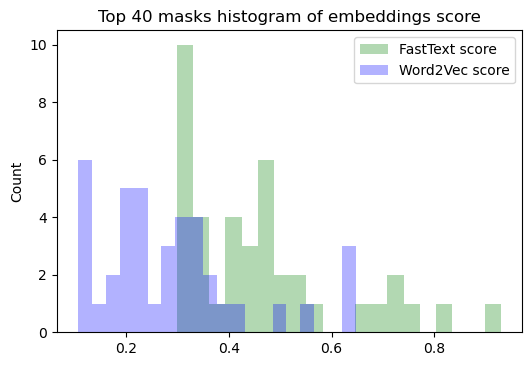

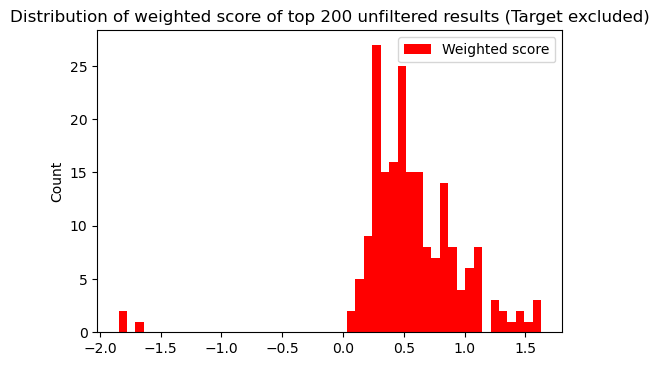

Original word position:  6 ; score:  56.70950698852539
Input:  what can you eat with type 2 diabetes?
Unfiltered top:
            word   bert normalized ftext  w2vec  score
0       diabetes  60.86       1.00  1.00   1.00   3.00
1       Diabetes  56.97       0.69  0.78   0.75   2.23
2       diabetic  51.92       0.30  0.77   0.75   1.81
3   hypertension  51.71       0.28  0.68   0.75   1.72
4        obesity  52.69       0.36  0.63   0.65   1.64
5        insulin  52.34       0.33  0.62   0.53   1.48
6    cholesterol  52.23       0.32  0.53   0.62   1.47
7        disease  51.58       0.27  0.57   0.58   1.42
8         sugars  53.15       0.40  0.43   0.36   1.19
9          sugar  53.07       0.39  0.44   0.26   1.09
10         blood  52.66       0.36  0.36   0.31   1.03
11        stress  51.48       0.26  0.22   0.19   0.68
12             D  52.50       0.34  0.07   0.11   0.53
13             A  51.86       0.29  0.04   0.00   0.33
14             ?  57.78       0.76  0.06  -2.00  -1.18
15

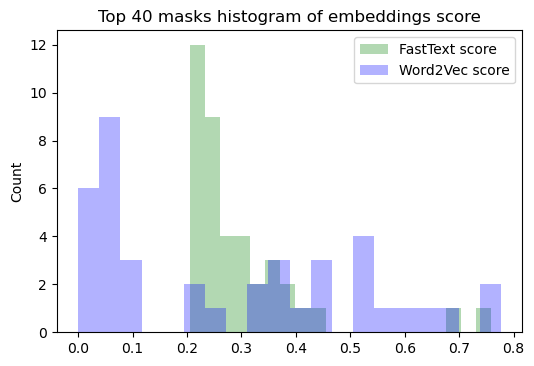

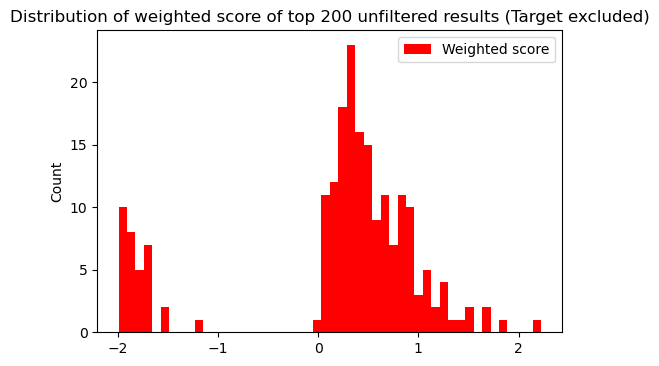

Original word position:  0 ; score:  60.86024475097656


In [85]:
for a in articles:
    do_find(a)

Input:  the quick brown fox? jumps over the lazy dog
Unfiltered top:
        word   bert normalized ftext w2vec score
0        fox  59.72       1.00  1.00  1.00  3.00
1        cat  57.97       0.78  0.49  0.58  1.85
2   squirrel  55.71       0.50  0.62  0.68  1.80
3     rabbit  55.57       0.49  0.63  0.65  1.77
4       wolf  55.26       0.45  0.68  0.57  1.70
5      snake  56.97       0.66  0.46  0.55  1.67
6        dog  56.62       0.62  0.46  0.53  1.61
7        pup  57.13       0.68  0.40  0.47  1.55
8      hound  56.26       0.57  0.54  0.41  1.52
9        rat  55.34       0.46  0.47  0.49  1.42
10    lizard  55.36       0.46  0.43  0.52  1.42
11     puppy  55.65       0.50  0.39  0.45  1.33
12      bear  55.25       0.45  0.41  0.36  1.21
13     mouse  55.52       0.48  0.37  0.33  1.19
14     horse  55.13       0.43  0.36  0.33  1.13
15  Labrador  55.18       0.44  0.33  0.30  1.07
16       one  56.63       0.62  0.11  0.09  0.82
17        ie  56.86       0.65  0.10  0.04  0.78


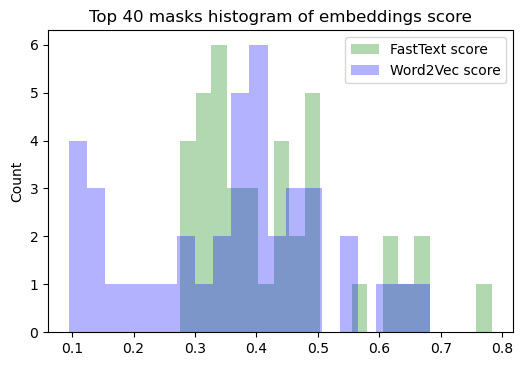

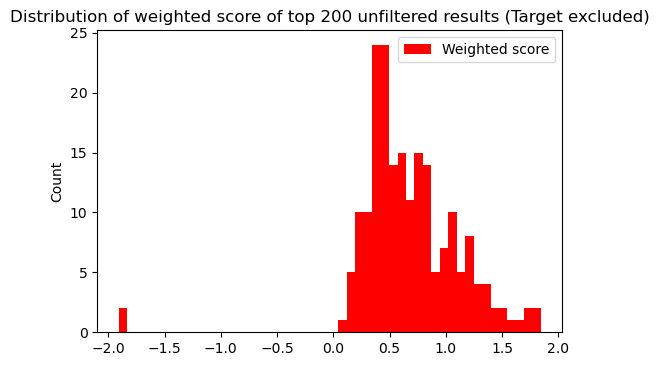

Original word position:  0 ; score:  59.7220573425293


In [86]:
# Example of usage
find_top(
    "the quick brown fox? jumps over the lazy dog", # mark target word with ?
    k = 20, # Filter best k results (by weighted score)
    top_bert = 200, # Number of initial filter of bert output 
    bert_norm = 200, # Use this position for normalization of bert output 
    min_ftext = 0.2, # Minimal required score of fast text  
    min_w2v = 0.2, # Minimal required score of fast text
    weights = [ # Weights of models scores to calculate total weighted score
        1, # bert
        1, # fast text
        1 # word2vec
    ]
)